In [56]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(420)
N = 500

In [62]:
import numpy as np

class EKalFilt:
       
    loss = np.zeros(N)
    covLog = np.zeros([2,N])
    n=1
    
    def __init__(self, ps, R, eps, Qeps, th, func):
        self.theta = th
        self.psize = ps
        self.P = eps * np.identity(ps) 
        self.Q = Qeps * np.identity(ps) 
        self.R = R
        self.f = func
        
        self.covLog[0,0] = self.theta[0].copy()
        self.covLog[1,0] = self.theta[1].copy()

        self.covLog[0,1] = self.theta[0].copy()
        self.covLog[1,1] = self.theta[1].copy()
    
    def predict_state(self):
        self.Pn1n1 = self.P.copy()
        self.P = self.P + self.Q
    
    def predict_point(self, x):
        return self.f(self.theta, x)
    
    def predict(self, x):
        self.predict_state()
        y = self.predict_point(x)
        return y
        
    def update(self, x, y):
        point_prediction = self.predict_point(x)
        error = y - point_prediction
        
        h = point_prediction * (1 - point_prediction) * x
        k = (self.P @ h) / (h.T @ self.P @ h + R)
        
        self.theta += k * error
        self.P = (np.identity(self.psize) - k @ h.T) @ self.P
        
        self.n+=1
        self.covLog[0,n] = self.theta[0].copy()
        self.covLog[1,n] = self.theta[1].copy()
        self.loss[n] = self.CrossEntropy(point_prediction, y)
        return error
    
    def CrossEntropy(self, yHat, y):
        if y == 1:
            return -np.log(yHat)
        else:
            return -np.log(1 - yHat)

In [58]:
def logisticReg(theta, x):
    return (1 + np.exp(-(theta.T @ x)))**-1

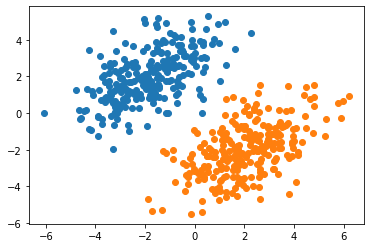

In [59]:
NumDataPerClass = int(N/2)
# Two-class problem, distinct means, equal covariance matrices
#
a = 2 
m1 = np.array([-a, a])
m2 = np.array([a, -a])
C = [[2, 1], [1, 2]]
# Set up the data by generating isotropic Guassians and
# rotating them accordingly
#
A = np.linalg.cholesky(C)

U1 = np.random.randn(NumDataPerClass,2)
X1 = U1 @ A.T + m1
Y1 = np.ones((NumDataPerClass, 1))

U2 = np.random.randn(NumDataPerClass,2)
X2 = U2 @ A.T + m2
Y2 = np.zeros((NumDataPerClass, 1))

X = np.vstack((X1, X2))
Y = np.vstack((Y1, Y2))
y = np.hstack((X, Y))
np.random.shuffle(y)

plt.scatter(X1[:, 0], X1[:,1])
plt.scatter(X2[:, 0], X2[:,1])

In [60]:
#KF parameters and initialisation
R = 0.1 * np.std(X[0:10]) # noise of dynamic function
eps = 0.001
Qeps = 0.001
theta = np.random.randn(2).reshape(-1,1)
ekf = EKalFilt(2, R, eps, Qeps, theta, logisticReg)

 #initialise var tracking
preds = np.zeros(N)
es = np.zeros(N)
x = np.zeros((2,1))

#run KF on S
for n in range(2, N):
    k = np.floor(np.random.rand()*N).astype(int)

    x[0] = y[k, 0]
    x[1] = y[k, 1]
    
    preds[n] = ekf.predict(x)
    es[n] = np.linalg.norm(ekf.update(x, y[k, 2]))

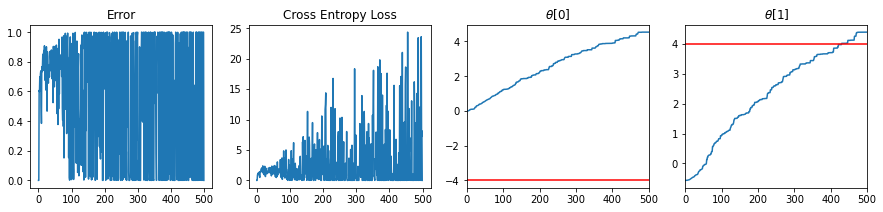

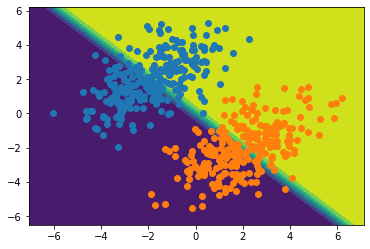

In [61]:
w = np.linalg.inv(C) @ (m1 - m2)

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(15,3))
ax[0].plot(es)
ax[0].set_title("Error")

ax[1].plot(ekf.loss)
ax[1].set_title("Cross Entropy Loss")

ax[2].plot(ekf.covLog[0])
ax[2].axhline(w[0],color='r')
ax[2].set_xlim(0,N)   
ax[2].set_title("$\\theta$[0]")

ax[3].plot(ekf.covLog[1])
ax[3].axhline(w[1],color='r')
ax[3].set_xlim(0,N)
ax[3].set_title("$\\theta$[1]")

fig.savefig("LogReg.png")
fig, ax = plt.subplots()
h = 0.1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = logisticReg(ekf.theta, [xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z)
ax.scatter(X1[:, 0], X1[:,1])
ax.scatter(X2[:, 0], X2[:,1])
#fig.savefig("DecisionBoundaryL.png")


KeyboardInterrupt: 

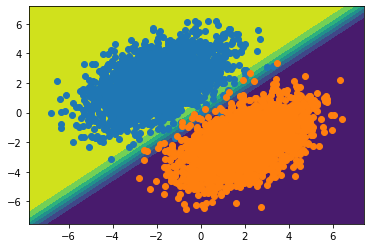

In [36]:
import imageio
import os

filenames = []

for i in ekf.covLog.T:
    # plot the line chart

    Z = logisticReg(i, [xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z)
    plt.scatter(X1[:, 0], X1[:,1])
    plt.scatter(X2[:, 0], X2[:,1])
    
    # create file name and append it to a list
    filename = f'imgs/{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
# build gif
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)